#Bert eval

In [1]:
import pandas as pd

translated_df = pd.read_csv('/content/random_translated_mental_health_chat_dataset.csv')


In [2]:
!pip install -q -U bitsandbytes
!pip install -q -U datasets
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U loralib
!pip install -q -U einops
!pip install hugchat==0.0.8

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
gcsfs 2024.6.1 requires fsspec==2024.6.1, but you have fsspec 2024.5.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyar

In [5]:
import json
import os
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers

from pprint import pprint
from tqdm import tqdm
from huggingface_hub import notebook_login
from peft import (
    LoraConfig,
    PeftConfig,
    PeftModel,
    get_peft_model,
    prepare_model_for_kbit_training
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig
)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [6]:
PEFT_MODEL = "thailevann/vinallama-mental-health_1"

config = PeftConfig.from_pretrained(PEFT_MODEL)
if not config.base_model_name_or_path:
    config.base_model_name_or_path = "vilm/vinallama-7b-chat"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    return_dict=True,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

tokenizer=AutoTokenizer.from_pretrained(config.base_model_name_or_path)
tokenizer.pad_token = tokenizer.eos_token

model = PeftModel.from_pretrained(model, PEFT_MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/709 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.80G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.67M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/160M [00:00<?, ?B/s]

In [8]:

generation_config = model.generation_config
generation_config.max_new_tokens = 1024
generation_config.temperature = 0.7
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = model.config.pad_token_id
generation_config.eos_token_id = model.config.eos_token_id
generation_config.no_repeat_ngram_size=3

generation_config.do_sample = True       # Sử dụng sampling

In [9]:
import re

def is_complete(text):
    # Kiểm tra xem văn bản có kết thúc bằng dấu chấm, dấu chấm than, hoặc ký tự xuống dòng không
    return re.search(r'(\.|!|\?)$', text) is not None

def get_complete_text(text):
    # Cắt văn bản dư thừa sau dấu chấm, dấu chấm than, hoặc ký tự xuống dòng cuối cùng
    match = re.search(r'(\.|!|\?)\s*$', text)
    if match:
        end_pos = match.end()
        return text[:end_pos]
    return text

def process_response(response):
    # Kiểm tra và cắt văn bản sinh ra
    if not is_complete(response):
        response = get_complete_text(response)
    return response


In [10]:
%%time
device = 'cuda' if torch.cuda.is_available() else 'cpu'

prompt = """
<|im_start|>system
Bạn là một chuyên gia về tham vấn sức khỏe tâm thần. Bạn sẽ nhận câu hỏi của người bệnh, hãy trả lời hoặc đưa ra lời khuyên dành cho họ.

<|im_start|>user
### Câu hỏi:
Tôi đang trải qua một số điều với cảm xúc của tôi và bản thân mình. Tôi hầu như không ngủ và không làm gì ngoài việc nghĩ về việc mình thật vô dụng và lẽ ra mình không nên ở đây. Tôi chưa bao giờ thử hoặc có ý định tự tử. Tôi luôn muốn giải quyết vấn đề của mình nhưng chưa bao giờ thực hiện được. Làm thế nào tôi có thể thay đổi cảm giác mình vô dụng đối với mọi người?
### Câu trả lời:

<|im_start|>assistant
""".strip()

encoding = tokenizer(prompt, return_tensors="pt").to(device)
with torch.inference_mode():
    outputs = model.generate(
        input_ids=encoding.input_ids,
        attention_mask=encoding.attention_mask,
        generation_config=generation_config
    )
response = tokenizer.decode(outputs[0], skip_special_tokens=True)
complete_response = process_response(response)

print(complete_response)

<|im_start|> system
Bạn là một chuyên gia về tham vấn sức khỏe tâm thần. Bạn sẽ nhận câu hỏi của người bệnh, hãy trả lời hoặc đưa ra lời khuyên dành cho họ.

<|im_start|> user
### Câu hỏi:
Tôi đang trải qua một số điều với cảm xúc của tôi và bản thân mình. Tôi hầu như không ngủ và không làm gì ngoài việc nghĩ về việc mình thật vô dụng và lẽ ra mình không nên ở đây. Tôi chưa bao giờ thử hoặc có ý định tự tử. Tôi luôn muốn giải quyết vấn đề của mình nhưng chưa bao giờ thực hiện được. Làm thế nào tôi có thể thay đổi cảm giác mình vô dụng đối với mọi người?
### Câu trả lời:

<|im_start|> assistant
Có rất nhiều cách để tìm hiểu về bản thân và những gì bạn có thể làm. Nếu bạn có một số tiền để làm việc, bạn có rất nhiều khả năng để tìm ra những gì là có thể cho bạn. Bạn có thể tìm thấy một số người có thể giúp đỡ bạn. Nếu không, bạn sẽ có thể có một vài người có khả năng giúp đỡ cho bạn và bạn có khả dụng để tìm kiếm một số sự giúp đỡ của bạn. Ví dụ, bạn cũng có thể nhận được một số lợi ích 

In [11]:
pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.1 MB/s eta 0:00:00


In [12]:
pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.5 MB/s eta 0:00:00


In [13]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=bfa3683329b5e956f292093cf28756b74fa90ef2c7f5ef7b6740db906e456586
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [15]:
%%time
from bert_score import score as bert_score
import sacrebleu
from rouge_score import rouge_scorer

device = 'cuda' if torch.cuda.is_available() else 'cpu'
results = []
for i, row in tqdm(translated_df.iterrows()):
    question_text_vi = row['questionText']
    answer_text_vi = row['answerText']
    prompt = f"""
    <|im_start|>system
    Bạn là một chuyên gia về tham vấn sức khỏe tâm thần. Bạn sẽ nhận câu hỏi của người bệnh, hãy trả lời hoặc đưa ra lời khuyên dành cho họ.

    <|im_start|>user
    ### Câu hỏi:
    {question_text_vi}
    ### Câu trả lời:

    <|im_start|>assistant
    """.strip()


    encoding = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.inference_mode():
        outputs = model.generate(
            input_ids=encoding.input_ids,
            attention_mask=encoding.attention_mask,
            generation_config=generation_config
        )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    complete_response = process_response(response)
    complete_response =  complete_response.split("<|im_start|> assistant")[-1]
    # Tính BERTScore
    P, R, F1 = bert_score([complete_response], [answer_text_vi], lang="vi", rescale_with_baseline=True)

    # Tính BLEU score
    bleu = sacrebleu.corpus_bleu([complete_response], [[answer_text_vi]]).score

    # Tính ROUGE score
    rouge_scorer_inst = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = rouge_scorer_inst.score(complete_response, answer_text_vi)

    # Lưu kết quả
    result = {
        'questionText': question_text_vi,
        'predictedAnswer': complete_response,
        'actualAnswer': answer_text_vi,
        'bert_score': {
            'precision': P.item(),
            'recall': R.item(),
            'f1': F1.item()
        },
        'bleu_score': bleu,
        'rouge_score': {
            'rouge1': rouge_scores['rouge1'].fmeasure,
            'rouge2': rouge_scores['rouge2'].fmeasure,
            'rougeL': rouge_scores['rougeL'].fmeasure
        }
    }
    results.append(result)

# Lưu kết quả vào file JSON
with open('bert_score_results.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

CPU times: user 41min 36s, sys: 18.1 s, total: 41min 54s
Wall time: 42min 30s


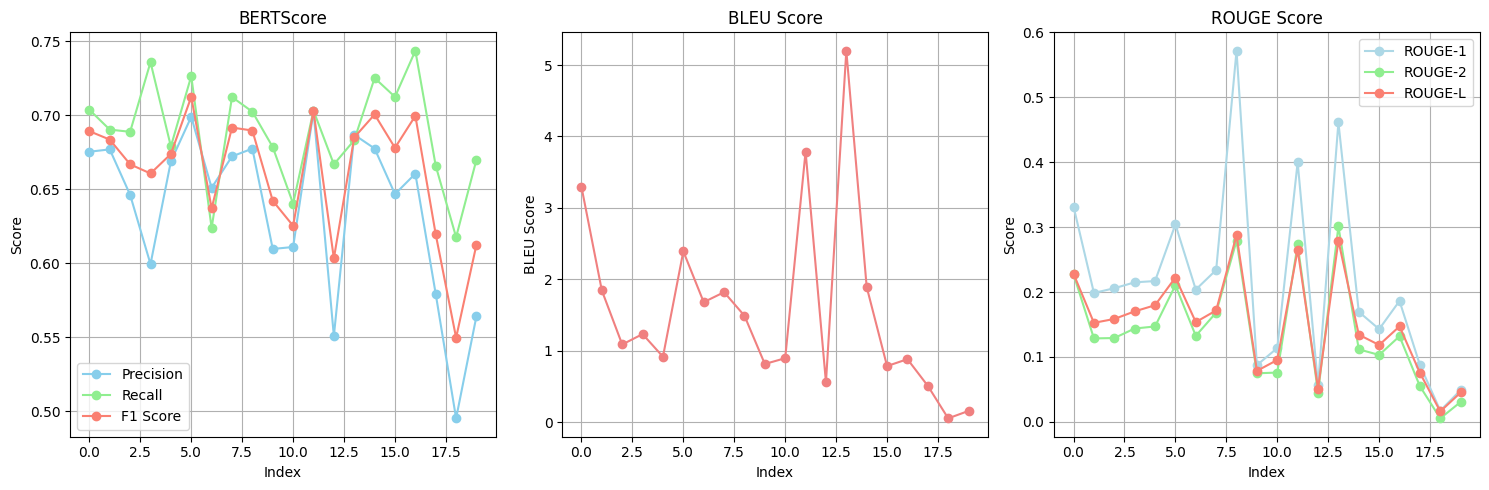

In [17]:
import json
import matplotlib.pyplot as plt

# Đọc dữ liệu từ tệp JSON
with open('bert_score_results.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Khởi tạo các danh sách để lưu trữ các giá trị cho từng chỉ số
precision = []
recall = []
f1 = []
bleu_scores = []
rouge1 = []
rouge2 = []
rougeL = []


# Duyệt qua từng đối tượng trong danh sách
for item in data:
    bert_scores = item["bert_score"]
    precision.append(bert_scores["precision"])
    recall.append(bert_scores["recall"])
    f1.append(bert_scores["f1"])

    bleu_scores.append(item["bleu_score"])

    rouge_scores = item["rouge_score"]
    rouge1.append(rouge_scores["rouge1"])
    rouge2.append(rouge_scores["rouge2"])
    rougeL.append(rouge_scores["rougeL"])

# Vẽ sơ đồ đường cho BERTScore
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(len(precision)), precision, marker='o', label='Precision', color='skyblue')
plt.plot(range(len(recall)), recall, marker='o', label='Recall', color='lightgreen')
plt.plot(range(len(f1)), f1, marker='o', label='F1 Score', color='salmon')
plt.xlabel('Index')
plt.ylabel('Score')
plt.title('BERTScore')
plt.legend()
plt.grid(True)

# Vẽ sơ đồ đường cho BLEU Score
plt.subplot(1, 3, 2)
plt.plot(range(len(bleu_scores)), bleu_scores, marker='o', color='lightcoral')
plt.xlabel('Index')
plt.ylabel('BLEU Score')
plt.title('BLEU Score')
plt.grid(True)

# Vẽ sơ đồ đường cho ROUGE Score
plt.subplot(1, 3, 3)
plt.plot(range(len(rouge1)), rouge1, marker='o', label='ROUGE-1', color='lightblue')
plt.plot(range(len(rouge2)), rouge2, marker='o', label='ROUGE-2', color='lightgreen')
plt.plot(range(len(rougeL)), rougeL, marker='o', label='ROUGE-L', color='salmon')
plt.xlabel('Index')
plt.ylabel('Score')
plt.title('ROUGE Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('score_trends.png')
plt.show()

